In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Distortion Correction

### Step 1 - Finding Chessboard corners

In this step, I am using the chessboard images taken at different camera angles provided in camera_cal folder to find the imagepoints corresponding to the real world object points using the **```cv2.findChessboardCorners```** function. This image points will be used in the next step to calculate 
1. **camera matrix (Intrinsic Parameters (focal length fx,fy and optical centers cx,cy))**
2. **Distortion co-efficients (K1,K2, K3 for radial distortion and P1,P2 for tangential distortion)**
3. **Rotation and translation vectors (Extrinsic Parameters)** 

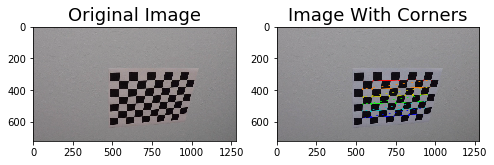

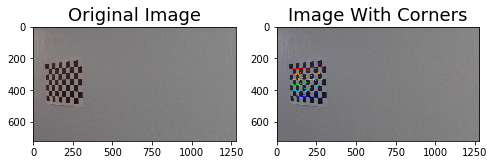

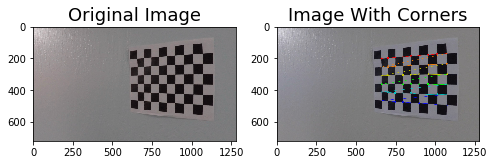

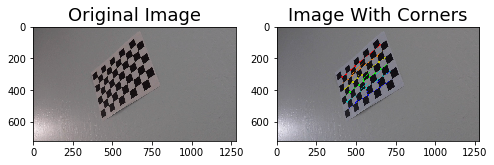

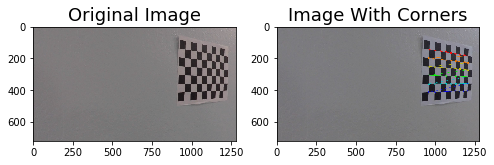

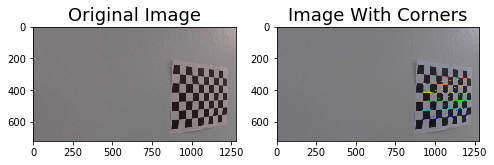

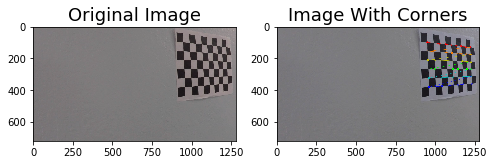

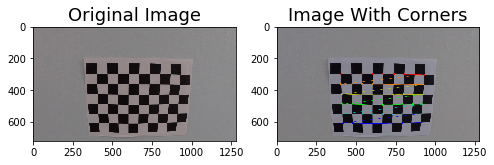

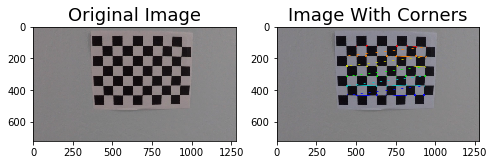

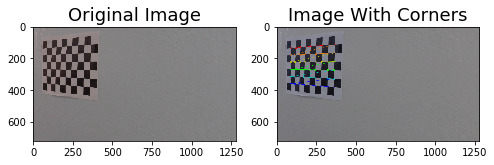

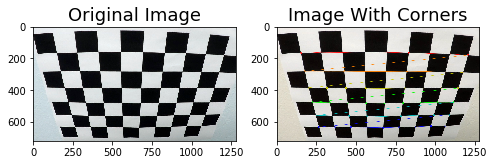

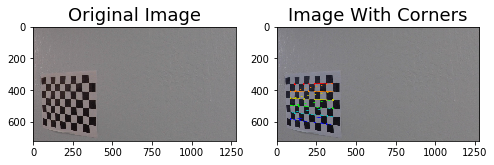

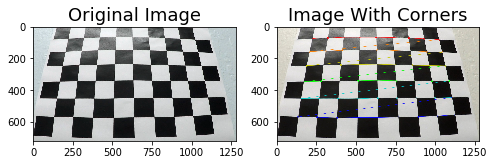

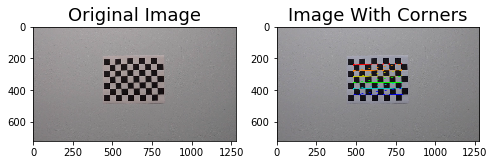

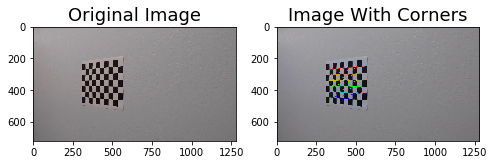

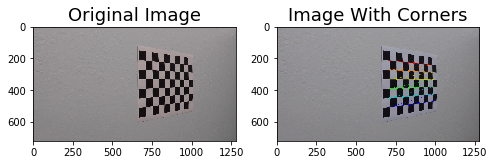

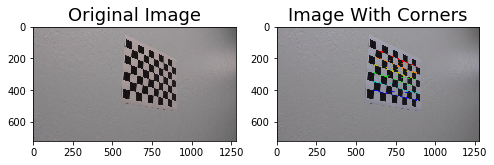

In [2]:
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(8,4))
        axis1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        axis1.set_title('Original Image', fontsize=18)
        axis2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axis2.set_title('Image With Corners', fontsize=18)

### Step 2 - Undistort the image

In this step, I will make use of the imagepoints that I got in the previous step to calculate camera calibration matrix and distortion coefficients to remove distortion from an image and output the undistorted image.

In [3]:
def undistort(image, show=True, read = True):
    if read:
        img = cv2.imread(image)
    else:
        img = image
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(9,6))
        axis1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axis1.set_title('Original Image', fontsize=20)
        axis2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        axis2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist

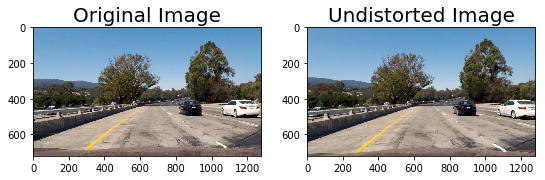

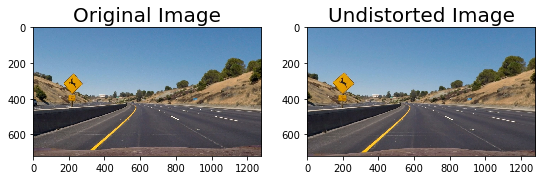

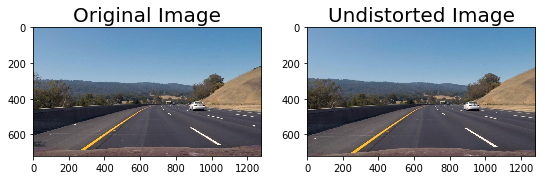

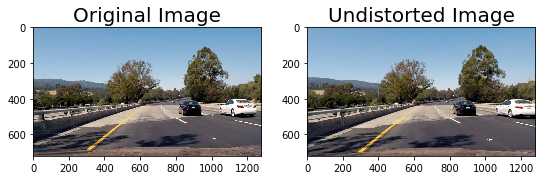

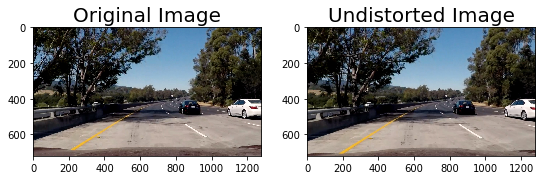

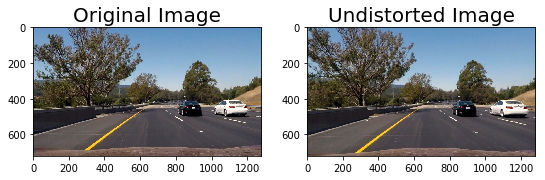

In [4]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)

## Perspective Transform

In this step I will define a function hawk_eye_view() that applies ```cv2.warpPerspective``` to the undistorted image to get a bird's eye view of the road that focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother. This will make it easier later on to fit polynomials to the lane lines and measure the curvature.

In [5]:
def hawk_eye_view(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(9, 6))
        fig.tight_layout()
        axis1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        axis1.set_title('Undistorted Image', fontsize=20)
        axis2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        axis2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

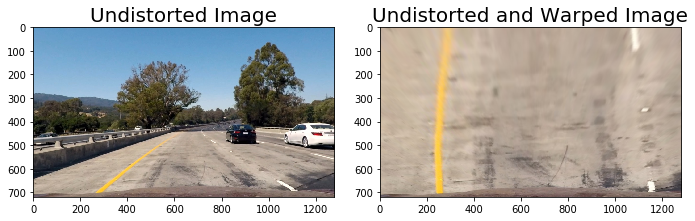

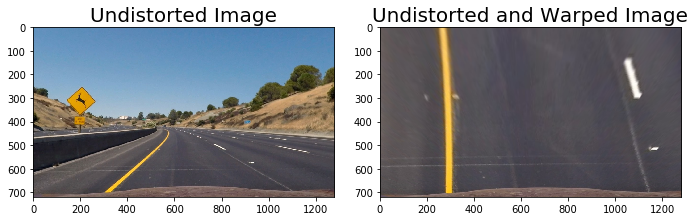

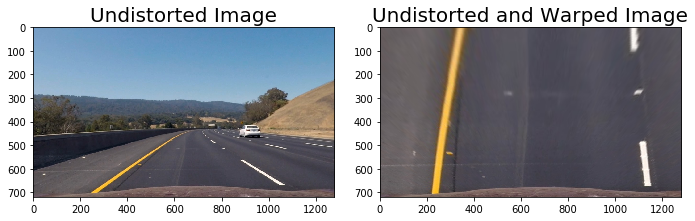

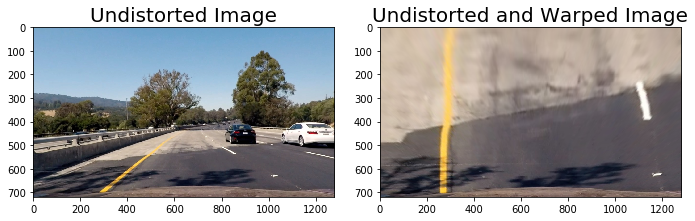

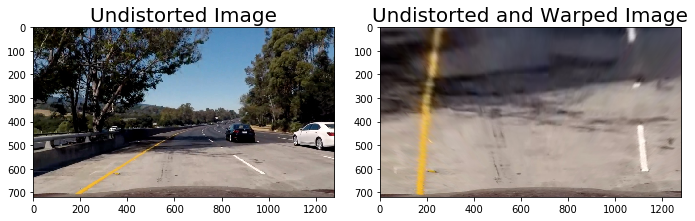

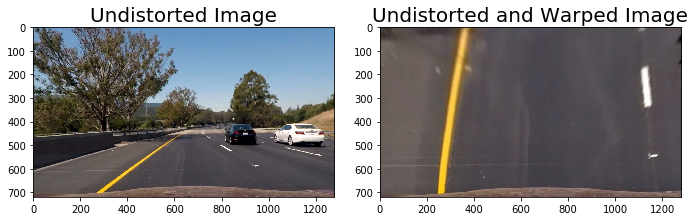

In [6]:
for image in glob.glob('test_images/test*.jpg'):
    hawk_eye_view(image)

## Apply Binary Thresholds

In this step I will convert the warped image to a different color space and create binary thresholded images which highlight only the lane lines. The following color spaces and thresholds are working fine for these images in identifying the lane lines.

1. L Channel from LUV color space with a min threshold of 215 and max threshold of 255 is picking up the white lane lines perfectly but completely missing yellow lane lines.

2. B Channel from LAB color space with a min threshold of 145 and max threshold of 200 is picking up the yellow lane lines perfectly but completely missing white lane lines.

Hence I am using a combined binary threshold with a combination of both L channel from LUV and B channel from LAB color space  to identify both the lane lines.


In [7]:
def binary_threshold(image, show=True, read=True):
    if read:
        img, M = hawk_eye_view(image, display = False)
    else:
        img, M = hawk_eye_view(image, display = False,read = False)

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    if show == True:
        # Plotting thresholded images
        fig, ((axis1, axis2, axis3), (axis4,axis5, axis6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        fig.tight_layout()
        
        axis1.set_title('Original Image', fontsize=16)
        axis1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        axis2.set_title('Warped Image', fontsize=16)
        axis2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        axis3.set_title('s binary threshold', fontsize=16)
        axis3.imshow(s_binary, cmap='gray')
        
        axis4.set_title('b binary threshold', fontsize=16)
        axis4.imshow(b_binary, cmap='gray')
        
        axis5.set_title('l binary threshold', fontsize=16)
        axis5.imshow(l_binary, cmap='gray')

        axis6.set_title('Combined color thresholds', fontsize=16)
        axis6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary

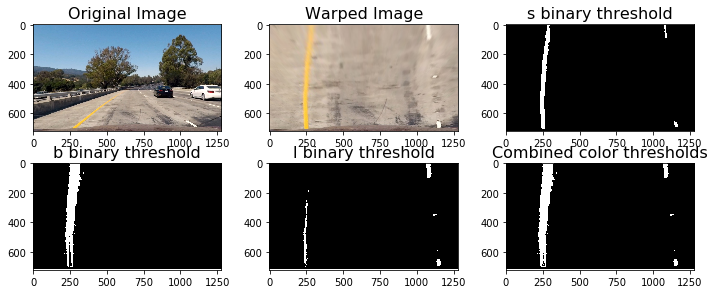

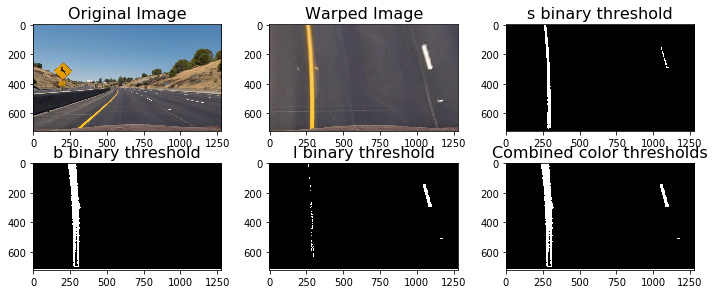

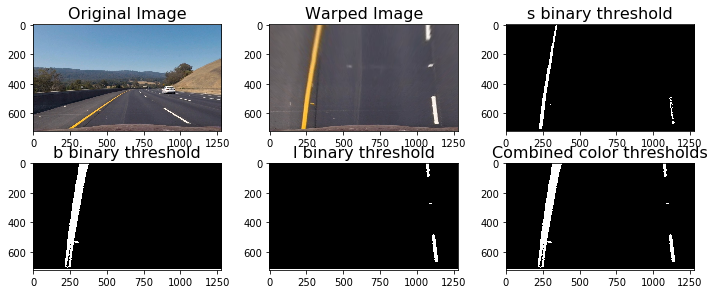

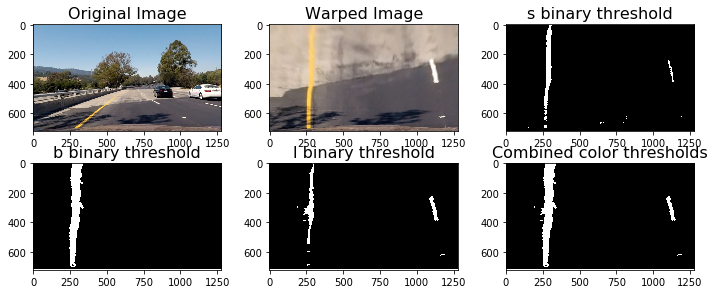

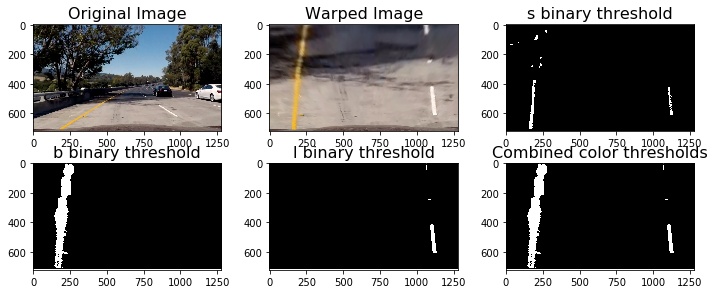

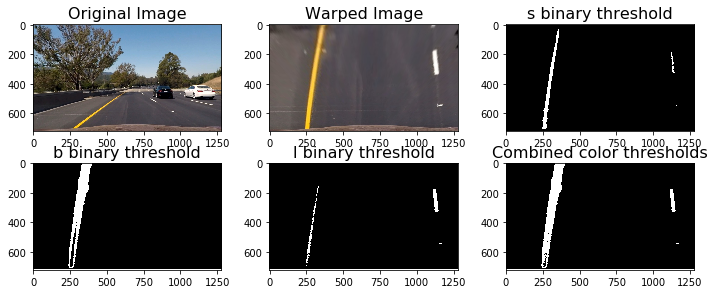

In [8]:
for image in glob.glob('./test_images/test*.jpg'):
    binary_threshold(image)

## Fitting a polynomial to the lane lines, calculating vehicle position and radius of curvature

Here I will make use of the above defined functions and fit a polynomial to each of the lane lines and highlight the space in between the idebtified lane lines. The position of the vehicle was measured by taking the average of the x intercepts of each line.

The equation for calculating radius of curvature was discovered at this page: http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In the function fill_lane_lines() below, lane lines are detected by identifying peaks in a histogram of the image and detecting nonzero pixels in close proximity to the peaks.

In [11]:
def fill_lane_lines(image):
    combined_binary = binary_threshold(image, show=False)
    size = combined_binary.shape[0]//2
    histogram = np.sum(combined_binary[size:,:], axis=0)
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 8
    window_height = np.int(combined_binary.shape[0]/nwindows)
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720) #To extrapolate the right lane line 
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)   #To extrapolate the right lane line
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)   #To extrapolate the left lane line
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)     #To extrapolate the left lane line
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 21./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/650 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty)*ym_per_pix + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty)*ym_per_pix + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    fig, (axis1, axis2) = plt.subplots(1,2, figsize=(9, 6))
    fig.tight_layout()
    axis1.imshow(cv2.cvtColor((hawk_eye_view(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    axis1.set_xlim(0, 1280)
    axis1.set_ylim(0, 720)
    axis1.plot(left_fitx, lefty, color='green', linewidth=3)
    axis1.plot(right_fitx, righty, color='green', linewidth=3)
    axis1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    axis1.invert_yaxis() # to visualize as we do the images
    axis2.imshow(result)
    axis2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        axis2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/650),
                 style='italic', color='white', fontsize=10)
    else:
        axis2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/650),
                 style='italic', color='white', fontsize=10)
    axis2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=10)
    


 ### Display of the lane lines, lane curvature and vehicle position.

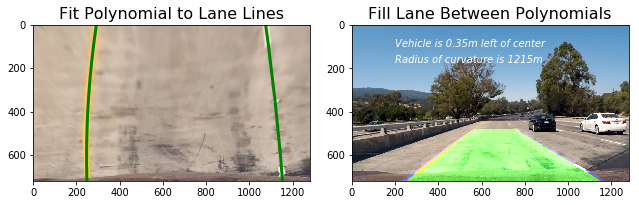

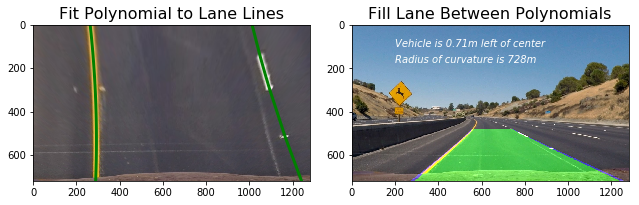

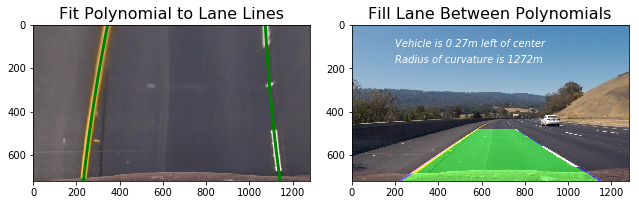

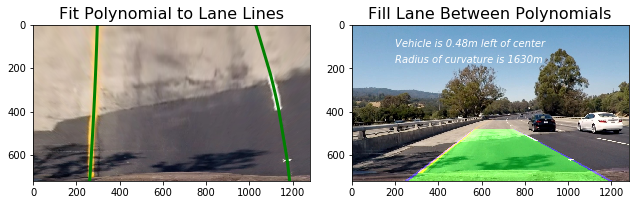

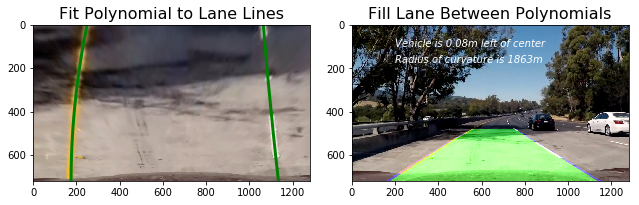

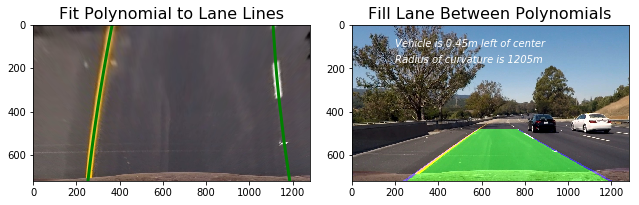

In [12]:
for image in glob.glob('test_images/test*.jpg'):
    fill_lane_lines(image)

## Video Processing Pipeline

First I will define a class Line() for the lines to store attributes about the lane lines from one frame to the next. Inside the class I will define several functions which will be used to detect the pixels belonging to each lane line.

In [13]:
class Line:
    def __init__(self):
        # Flag to indicate whether Lane found in earlier frame or not 
        self.found = False
        
        # x and y values of Lanes from previous frames
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a sliding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        
        xvals = []
        yvals = []
        
        if self.found == False: 
            #Defining a search window that is used iteratively from bottom of the image to top along
            #those pixels that represents the peak of the histogram
            window_base = int(image.shape[0])
            midpoint = int(image.shape[1]//2)
            n_windows = 8
            margin = 25
            window_height = int(window_base//n_windows)
            window_top = window_base - window_height            
            while window_top >= 0:
                histogram = np.sum(image[window_top:window_base,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[midpoint:]) + midpoint
                else:
                    peak = np.argmax(histogram[:midpoint])
                x_idx = np.where((((peak - margin) < x)&(x < (peak + margin))&((y > window_top) & (y < window_base))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                window_base -= window_height
                window_top -= window_height              
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
 
    
    def found_search(self, x, y, image):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close vicinity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        
        xvals = []
        yvals = []
        
        if self.found == True: 
            #Defining a search window that is used iteratively from bottom of the image to top along
            #the fitted polynomial
            window_base = int(image.shape[0]) 
            midpoint = int(image.shape[1]//2)
            n_windows = 8
            margin = 25
            window_height = int(window_base//n_windows)
            window_top = window_base - window_height
            while window_top >= 0:
                yval = np.mean([window_base,window_top])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - margin) < x)&(x < (xval + margin))&((y > window_top) & (y < window_base))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                window_base -= window_height
                window_top -= window_height
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
        
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 21./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/650 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals)*ym_per_pix + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

Here I will create a function process_video() which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.

The video processing pipeline is similar to the fill_lane_lines() function created earlier in the notebook except that the video pipeline stores information about the lane lines across frames to average the lane positions and ensures a smooth output which is less impacted by outliers.

The video pipeline also knows whether or not the lane line was detected in the previous frame, and if it was, it only checks for lane pixels in a tight window around the previous polynomial, ensuring a high confidence detection. If the lane line was not detected in the previous frames (and for the first 5 frames of the video) The pipeline performs the same search which was performed in the fill_lane_lines() function based on identifying peaks in a histogram.

In [14]:
# Video Processing Pipeline
def process_video(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    midpoint = int(image.shape[1]//2)
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y, combined_binary)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y, combined_binary)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)

    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((midpoint - position)*3.7/650) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > midpoint:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [16]:
Left = Line()
Right = Line()
video_output = 'samp_result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video samp_result.mp4
[MoviePy] Writing video samp_result.mp4


 98%|█████████████████████████████████████████▏| 50/51 [00:44<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: samp_result.mp4 



In [17]:
Left = Line()
Right = Line()
challenge_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
challenge_clip = clip1.fl_image(process_video) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [20:19<00:00,  1.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [18]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_video) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|████████████████████████████████████████| 485/485 [07:17<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 

